In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)  # (num, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot

latent_dim = 2

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

# Encoder
image_inputs = tf.keras.Input(shape=(28, 28, 1))
label_inputs = tf.keras.Input(shape=(10,))
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(image_inputs)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Concatenate()([x, label_inputs])
x = layers.Dense(128, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model([image_inputs, label_inputs], [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
decoder_label_inputs = tf.keras.Input(shape=(10,))
x = layers.Concatenate()([latent_inputs, decoder_label_inputs])
x = layers.Dense(7 * 7 * 64, activation='relu')(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model([latent_inputs, decoder_label_inputs], decoder_outputs, name="decoder")

# CVAE as subclassed model
class CVAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, data):
        x, y = data  # x: image, y: label
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x, y])
            x_recon = self.decoder([z, y])
            recon_loss = self.bce(tf.reshape(x, [tf.shape(x)[0], -1]),
                                  tf.reshape(x_recon, [tf.shape(x)[0], -1]))
            recon_loss *= 28 * 28

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

# Instantiate and train
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())
cvae.fit(x_train, y_train, epochs=10, batch_size=128)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - kl_loss: 2.2123 - loss: 173.0606 - recon_loss: 170.8483
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7018 - loss: 134.5659 - recon_loss: 131.8641
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 2.7354 - loss: 132.2400 - recon_loss: 129.5046
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 2.7514 - loss: 131.0743 - recon_loss: 128.3228
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 2.7666 - loss: 130.2975 - recon_loss: 127.5309
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7672 - loss: 129.7561 - recon_loss: 126.9889
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7781 - loss: 129.2141 - recon_loss: 126.4360
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7654 - loss: 128.8304 - recon_loss: 126.0649
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7793 - loss: 128.5666 - recon_loss: 125.7873
Epoch 10/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


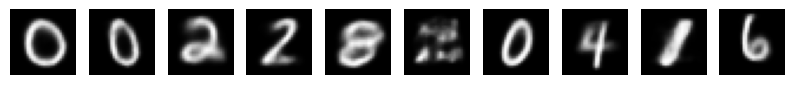

In [16]:
import random

# Generate random latent vectors and one-hot labels
num_samples = 10
random_latents = tf.random.normal(shape=(num_samples, latent_dim))

# Generate class codes (one-hot)
random_labels = tf.keras.utils.to_categorical(
    [random.randint(0, 9) for _ in range(num_samples)], num_classes=10
)

# Generate images
generated_images = cvae.decoder.predict([random_latents, random_labels])

# Plot the images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


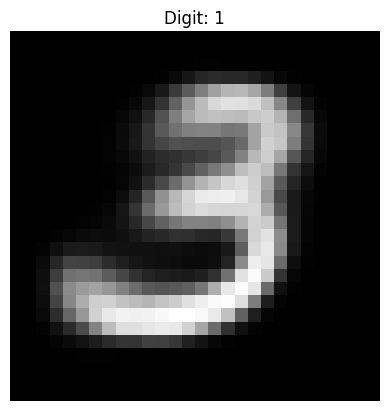

In [67]:
# Single latent vector and label (for digit 0)
random_latent = tf.random.normal(shape=(latent_dim,))
label = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

# Expand dims to make batch size = 1
random_latent = tf.expand_dims(random_latent, 0)  # (1, latent_dim)
label = tf.expand_dims(label, 0)                  # (1, 10)

# Generate image
generated_image = cvae.decoder.predict([random_latent, label])

# Plot the generated image
plt.imshow(generated_image[0].squeeze(), cmap='gray')
plt.title("Digit: 1")
plt.axis("off")
plt.show()


In [74]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ===== Hyperparameters =====
latent_dim = 2
num_classes = 10
embedding_dim = 8

# ===== Sampling Layer =====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ===== Encoder =====
image_inputs = tf.keras.Input(shape=(28, 28, 1))
label_inputs = tf.keras.Input(shape=(), dtype='int32')

label_embed = layers.Embedding(input_dim=num_classes, output_dim=embedding_dim)(label_inputs)
label_embed = layers.Flatten()(label_embed)

x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(image_inputs)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Concatenate()([x, label_embed])
x = layers.Dense(128, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model([image_inputs, label_inputs], [z_mean, z_log_var, z], name="encoder")

# ===== Decoder =====
latent_inputs = tf.keras.Input(shape=(latent_dim,))
decoder_label_inputs = tf.keras.Input(shape=(), dtype='int32')

label_embed_d = layers.Embedding(input_dim=num_classes, output_dim=embedding_dim)(decoder_label_inputs)
label_embed_d = layers.Flatten()(label_embed_d)

x = layers.Concatenate()([latent_inputs, label_embed_d])
x = layers.Dense(7 * 7 * 64, activation='relu')(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model([latent_inputs, decoder_label_inputs], output, name="decoder")

# ===== CVAE Model =====
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(CVAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([images, labels])
            reconstructed = self.decoder([z, labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(images, reconstructed)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ===== Instantiate and Compile =====
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())


In [75]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, -1)

cvae.fit(x_train, y_train, epochs=10, batch_size=128)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - kl_loss: 16.1130 - loss: 31052.5820 - reconstruction_loss: 31036.4727
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 17.2361 - loss: 17373.0508 - reconstruction_loss: 17355.8145
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 14.8979 - loss: 16697.4297 - reconstruction_loss: 16682.5312
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 13.9003 - loss: 16490.2363 - reconstruction_loss: 16476.3457
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 13.6931 - loss: 16355.6465 - reconstruction_loss: 16341.9541
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 13.3763 - loss: 16221.7471 - reconstruction_loss: 16208.3711
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 12.9955 - loss: 16189.5049 - reconstruction_loss: 16176.5049
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 12.8315 - loss: 16114.8955 - reconstruction_loss: 16102.0635
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


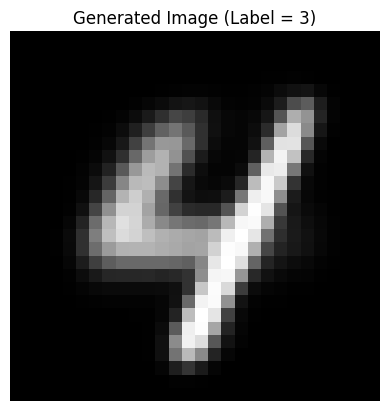

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Sample latent vector and label =====
sample_latent = np.random.normal(size=(1, latent_dim))  # shape (1, 2)
sample_label = np.array([4])  # class label, e.g., '3'

# ===== Generate image from decoder =====
generated_image = decoder.predict([sample_latent, sample_label])

# ===== Display the image =====
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.title("Generated Image (Label = 3)")
plt.show()


In [111]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST and normalize
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Expand dims to (batch, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Blur function: downsample and upsample
def blur_images(images):
    images_small = tf.image.resize(images, [14, 14])
    images_blurred = tf.image.resize(images_small, [28, 28])
    return images_blurred

x_train_blur = blur_images(x_train)
x_test_blur = blur_images(x_test)

print("Train data shape:", x_train.shape)      # (60000, 28, 28, 1)
print("Blurred input shape:", x_train_blur.shape)  # (60000, 28, 28, 1)

latent_dim = 16

# ----- Encoder -----
encoder_input = tf.keras.Input(shape=(28, 28, 1))  # (None, 28, 28, 1)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_input)  # (None, 14, 14, 32)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)              # (None, 7, 7, 64)
x = layers.Flatten()(x)                                                                # (None, 3136)
x = layers.Dense(128, activation='relu')(x)                                            # (None, 128)
z_mean = layers.Dense(latent_dim)(x)                                                   # (None, 16)
z_log_var = layers.Dense(latent_dim)(x)                                                # (None, 16)

# ----- Sampling -----
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))  # (None, 16)
        return z_mean + tf.exp(0.5 * z_log_var) * eps

z = Sampling()([z_mean, z_log_var])  # (None, 16)

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# ----- Decoder -----
decoder_input = tf.keras.Input(shape=(latent_dim,))                 # (None, 16)
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)      # (None, 3136)
x = layers.Reshape((7, 7, 64))(x)                                   # (None, 7, 7, 64)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # (None, 14, 14, 64)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # (None, 28, 28, 32)
decoder_output = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)  # (None, 28, 28, 1)

decoder = Model(decoder_input, decoder_output, name="decoder")

# ----- Training Loop with GradientTape -----
batch_size = 128
epochs = 5
optimizer = tf.keras.optimizers.Adam()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_blur, x_train)).shuffle(1024).batch(batch_size)

for epoch in range(epochs):
    total_loss = 0
    for step, (blurry_batch, clean_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(blurry_batch)
            reconstruction = decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(clean_batch, reconstruction)
            ))

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            loss = recon_loss + kl_loss

        grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, encoder.trainable_weights + decoder.trainable_weights))
        total_loss += loss.numpy()

    print(f"Epoch {epoch+1}, Loss: {total_loss / (step+1):.4f}")

Train data shape: (60000, 28, 28, 1)
Blurred input shape: (60000, 28, 28, 1)
Epoch 1, Loss: 20118.9071
Epoch 2, Loss: 10411.7257
Epoch 3, Loss: 9464.1532
Epoch 4, Loss: 9108.7165
Epoch 5, Loss: 8908.1896


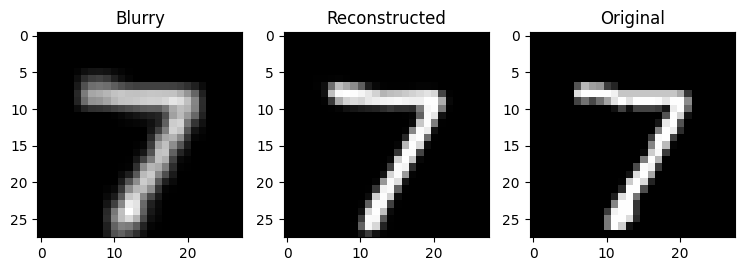

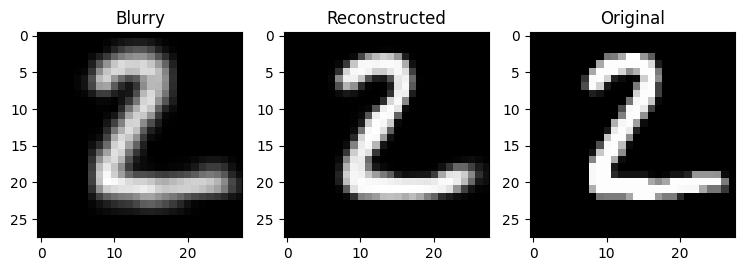

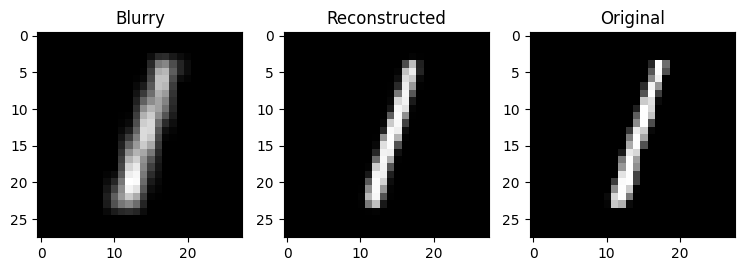

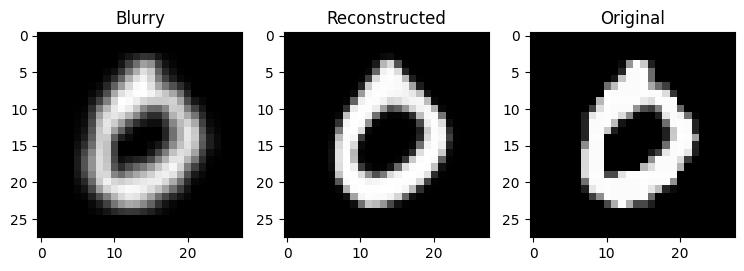

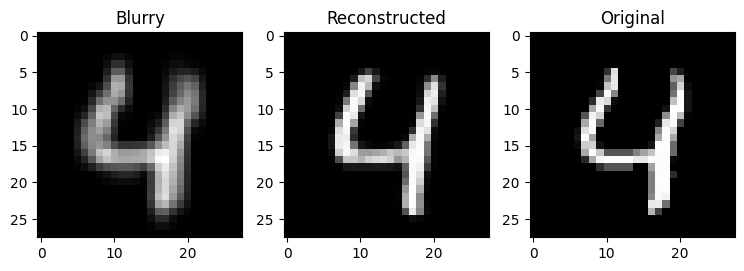

In [121]:
import matplotlib.pyplot as plt

# Pass label if your encoder expects it
z_mean, z_log_var, z_sample = encoder(x_test_blur[:10])  # include labels
recon = decoder(z_sample)

for i in range(5):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(1, 3, 1)
    plt.title("Blurry")
    plt.imshow(x_test_blur[i], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed")
    plt.imshow(recon[i], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Original")
    plt.imshow(x_test[i], cmap='gray')
    
    plt.show()


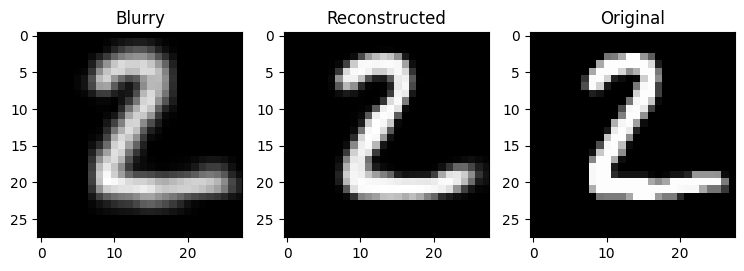

In [133]:
    z_mean, z_log_var, z_sample = encoder(x_test_blur[:2])
    recon = decoder(z_sample)

    plt.figure(figsize=(9, 3))
    
    plt.subplot(1, 3, 1)
    plt.title("Blurry")
    plt.imshow(x_test_blur[1], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed")
    plt.imshow(recon[1], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Original")
    plt.imshow(x_test[1], cmap='gray')
    
    plt.show()
